# US EPA Air Quality Index of Odessa, TX from 1964 - 2024

## License
Some code below was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.2 - August 16, 2024

Import relevant libraries

In [1]:
import json, time
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

## Sign up for US EPA API
Only need to be done once. After you've acquired your API key, use that for all the following data acquisition process

In [3]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")

    if '@' not in request_template['email']: 
        raise Exception(f"Must supply an email address to call 'request_signup()'. The string '{request_template['email']}' does not look like an email address.")

    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [5]:
#
#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
#
print("Requesting SIGNUP ...")
USERNAME = "tchiang0@uw.edu"
response = request_signup(USERNAME)
print(json.dumps(response,indent=4))

Requesting SIGNUP ...
{
    "Header": [
        {
            "status": "Success",
            "request_time": "2024-11-16T18:36:27-05:00",
            "url": "https://aqs.epa.gov/data/api/signup?email=tchiang0@uw.edu"
        }
    ],
    "Data": [
        "You should receive an email containing your new key shortly."
    ]
}


After you've activated your account from the email, you can put your `USERNAME` (your email) and the `APIKEY` given in the email

In [6]:
USERNAME = "tchiang0@uw.edu"
APIKEY = "aquagazelle52"

In [7]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

Get the list of all the AQI pollutants

In [8]:
AQI_PARAM_CLASS = "AQI POLLUTANTS"
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


Separate the AQI pollutants into two categories for the API call (API call only takes five parameters at once)

In [9]:
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

My assigned city is Odessa, TX

In [10]:
CITY_LOCATIONS = {
    "odessa": {"city"   : "Odessa",
               "county" : "Ector",
               "state"  : ["Texas", "TX"],
               "fips"   : "48135",
               "latlon" : [31.88, -102.35] } 
}

In [11]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

To obtain the annual AQI, I developed a `request_yearly_summary` function. This function accepts either `AQI_PARAMS_GASEOUS` or `AQI_PARAMS_PARTICULATES` as parameters, along with the target year and the request_data input. It outputs a list summarizing air quality data from the US EPA Air Quality API. \
Given that the annual fire season is defined as running from May 1st to October 31st, we set the `begin_date` and `end_date` parameters within the `request_daily_summary` function to reflect this seasonal period.

In [12]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['odessa']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['odessa']['fips'][2:]


def request_yearly_summary(params, year, request_data):
    """Gets the annual fire season Air quality summary of the specified param, year, and request data"""
    request_data['param'] = params
    gaseous_aqi = request_daily_summary(request_template = request_data, begin_date = f"{year}0501", end_date = f"{year}1031")

    if gaseous_aqi["Header"][0]["status"] == "Success":
        return gaseous_aqi["Data"]
    return None

Request the yearly summary aqi for gaseous pollutants (CO, SO2, NO2, and O2) and save the output to `df_gas_aqi`

In [13]:
# range() function has an exclusive end, so range(1964, 2025) gets years from 1964-2024, inclusively
years = [str(y) for y in range(1964, 2025)]
gas_aqi_list = []
for y in years:
    gas_agi = request_yearly_summary(AQI_PARAMS_GASEOUS, y, request_data)
    if not gas_agi:
        continue
    gas_aqi_list += gas_agi

In [14]:
df_gas_aqi = pd.DataFrame(gas_aqi_list)

Request the yearly summary aqi for particulates pollutants (PM10, PM2.5, and Acceptable PM2.5) and save the output to `df_particupates_aqi`

In [15]:
years = [str(y) for y in range(1964, 2025)]
particulates_aqi_list = []
for y in years:
    particulates_aqi = request_yearly_summary(AQI_PARAMS_PARTICULATES, y, request_data)
    if not particulates_aqi:
        continue
    particulates_aqi_list += particulates_aqi

In [16]:
df_particulates_aqi = pd.DataFrame(particulates_aqi_list)

Keep only the relevant columns (`date_local` and `aqi`) and get the annual mean AQI for each available year for both `df_gas_aqi` and `df_particulates_aqi`

In [17]:
# for gaseous pollutants CO, SO2, NO2, and O2
df_gas_data_aqi = df_gas_aqi[["date_local", "aqi"]].copy()  # .copy() avoids changing the df_gas_aqi dataframe
df_gas_data_aqi['date_local'] = pd.to_datetime(df_gas_data_aqi['date_local'])
# drop all missing aqi values
df_gas_data_aqi.dropna(subset=["aqi"], inplace=True)
# get the annual mean of aqi for each available year
yearly_gas_aqi_mean = df_gas_data_aqi.groupby(df_gas_data_aqi['date_local'].dt.year)['aqi'].mean().reset_index()


In [18]:
# for particulates pollutants PM10, PM2.5, and Acceptable PM2.5
df_part_data_aqi = df_particulates_aqi[["date_local", "aqi"]].copy()
df_part_data_aqi['date_local'] = pd.to_datetime(df_part_data_aqi['date_local'])
# drop all missing aqi values
df_part_data_aqi.dropna(subset=["aqi"], inplace=True)
# get the annual mean of aqi for each available year
yearly_part_aqi_mean = df_part_data_aqi.groupby(df_part_data_aqi['date_local'].dt.year)['aqi'].mean().reset_index()

Concatenate both `yearly_gas_aqi_mean` and `yearly_part_aqi_mean`, group by each year, and take the mean of both aqis to get the annual mean aqi considering both gaseous and particulate pollutants

In [19]:
yearly_full_aqi_mean = pd.concat([yearly_gas_aqi_mean, yearly_part_aqi_mean])
yearly_full_aqi_mean = yearly_full_aqi_mean.groupby("date_local")['aqi'].mean().reset_index()

Read in the `df_within_650_miles_away_from_odessa_from_1964` for the third visualization

In [20]:
df_within_650_miles_away_from_odessa_from_1964 = pd.read_csv("data_intermediate/df_within_650_miles_away_from_odessa_from_1964.csv")

From `df_within_650_miles_away_from_odessa_from_1964`, group by each year, and get the mean estimated smoke density for each year

In [21]:
df_smoke_estimate_by_year = df_within_650_miles_away_from_odessa_from_1964.groupby('fire_year')['smoke_density_estimate'].mean().reset_index()

In [53]:
df_smoke_estimate_by_year.to_csv("df_smoke_estimate_by_year.csv", index=False)

### Visual 3: Annual Mean AQI and Annual Mean Smoke Density Estimates from 1964 to 2024
A time series graph showing the mean annual smoke density estimates and mean annual AQI for Odessa, TX, for each fire season, defined as running from May 1st through October 31st.

The left y-axis (in blue) is the AQI and the right y-axis (in red) is the smoke density (µg/m³)

Notice there are some missing data from both the AQI dataset and the wildfire dataset. The time series nature of the graph connects the available data points, yielding an "estimate" for the missing data points. However, that might not be an accurate depiction of either the mean AQI or the mean estimated smoke density for that year.

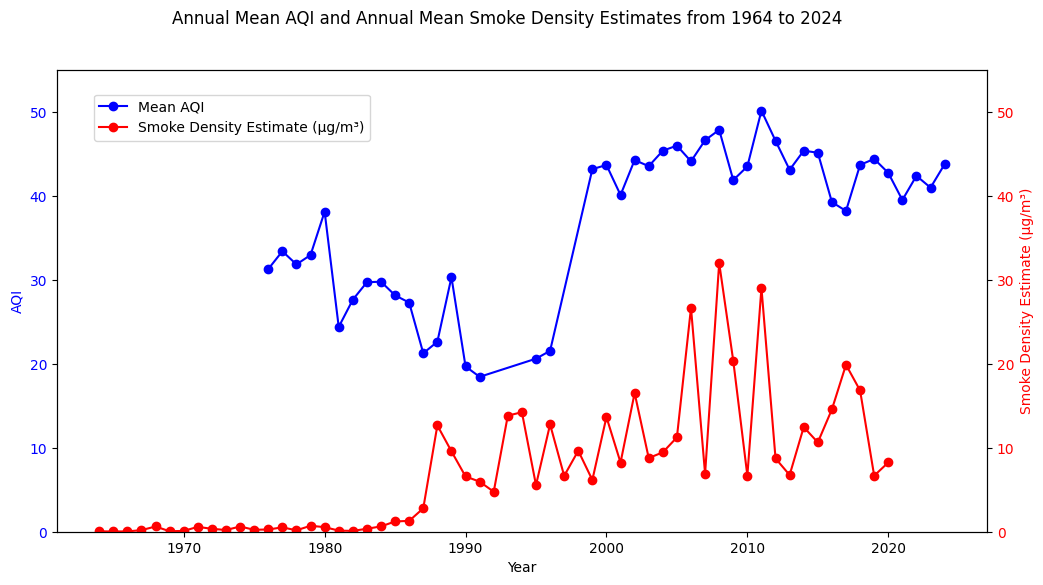

In [22]:
# missing some years
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(yearly_full_aqi_mean['date_local'], yearly_full_aqi_mean['aqi'], marker = 'o', color='b')
ax1.set_xlabel("Year")
ax1.set_ylabel("AQI", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylim(0, 55)

ax2 = ax1.twinx()
ax2.plot(df_smoke_estimate_by_year['fire_year'], df_smoke_estimate_by_year['smoke_density_estimate'], marker='o', color='r')
ax2.set_ylabel("Smoke Density Estimate (µg/m³)", color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, 55)
fig.suptitle("Annual Mean AQI and Annual Mean Smoke Density Estimates from 1964 to 2024")
fig.legend(['Mean AQI', 'Smoke Density Estimate (µg/m³)'], loc="upper left", bbox_to_anchor=(0.15, 0.85))

plt.show()


## Wildfire Smoke Estimate for 1964 - 2024 and Forecast for 2025 - 2050

Autoregressive Integrated Moving Average (ARIMA), a statistical model used to forecast future values in time series data

In [91]:
from statsmodels.tsa.arima.model import ARIMA

# fit the ARIMA model with the smoke estimate with order (1, 2, 1)
model = ARIMA(df_smoke_estimate_by_year['smoke_density_estimate'], order=(1, 2, 1))
model_fit = model.fit()

# estimate historical smoke data
y_pred = model_fit.predict()
df_fitted_smoke_est = pd.DataFrame(
    {"fire_year": df_smoke_estimate_by_year["fire_year"],
     "fitted_smoke_estimate": y_pred}
)

/Users/dianechiang/Desktop/data_512/data_512_project/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [106]:
 # index of the first forecasted year
forecast_start = len(df_smoke_estimate_by_year)
# number of years to forecast (29 instead of 25 since we don't have data between 2021 - 2024)
forecast_end = forecast_start + 29

# forecast smoke for 2021 - 2050
forecast = model_fit.predict(start=forecast_start, end=forecast_end)
forecast_years = pd.date_range(start="2021", end="2051", freq="Y")

# Convert forecast to a DataFrame for better readability
forecast_df = pd.DataFrame({
    "fire_year": forecast_years,
    "smoke_density_estimate": forecast.values
})

# concatenate two dataframes together
d = {'fire_year': [y for y in range(2021, 2051)], 'fitted_smoke_estimate': list(forecast)}
df_predicted_smoke_density = pd.DataFrame(data = d)
df_total = pd.concat([df_fitted_smoke_est, df_predicted_smoke_density], axis=0)

/var/folders/g6/2vpn8j992hg688vyx5njjx_r0000gn/T/ipykernel_17116/2913646528.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_years = pd.date_range(start="2021", end="2051", freq="Y")


Plot Smoke Estimate (blue) and Forecast (red)

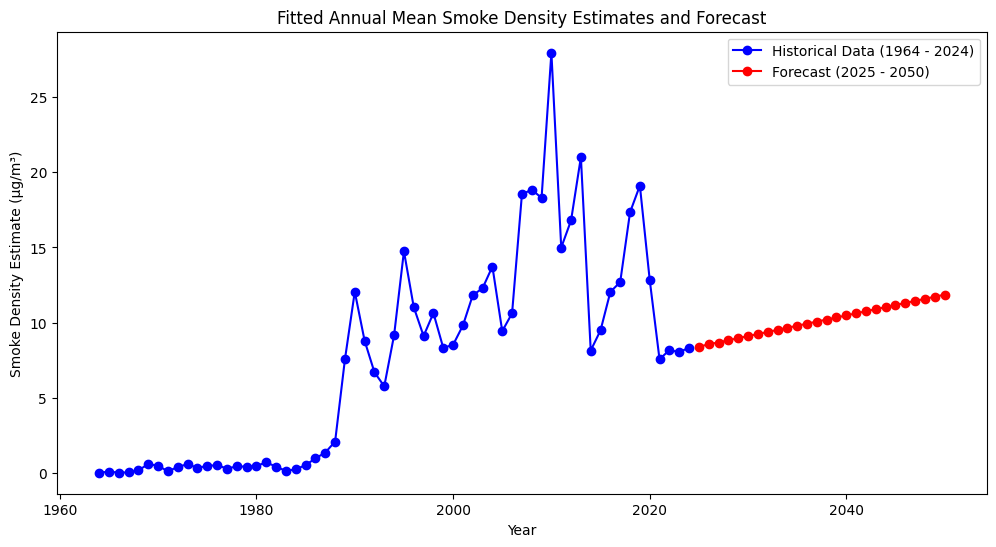

In [132]:
plt.subplots(figsize=(12, 6))

historical_year = [year for year in df_total["fire_year"] if year <= 2024]
forecast_year = [year for year in df_total["fire_year"] if year > 2024]

historical_smoke = df_total[df_total["fire_year"].isin(historical_year)]["fitted_smoke_estimate"]
forecast_smoke = df_total[df_total["fire_year"].isin(forecast_year)]["fitted_smoke_estimate"]

plt.plot(historical_year, historical_smoke, 'o-', color='blue', label='Historical Data (1964 - 2024)')
plt.plot(forecast_year, forecast_smoke, 'o-', color='red', label='Forecast (2025 - 2050)')

plt.xlabel('Year')
plt.ylabel('Smoke Density Estimate (µg/m³)')
plt.title('Fitted Annual Mean Smoke Density Estimates and Forecast')

plt.legend()

plt.show()

In [133]:
df_total.to_csv("data_intermediate/Smoke Estimate using ARIMA.csv", index=False)